# VGG ARCHITECTURE

This notebook implement the VGG architecture for image recognition using CNN.
You can find the paper describing this architecture by following the link:
https://arxiv.org/pdf/1409.1556.pdf

**Here is the global architecture of a VGG network : **
<img src="images/vgg.png" style="width:470px;height:276px;">

In [2]:
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def loadFile(fileName):
    array = np.load(fileName)
    
    return array

In [4]:
def showImage(inTainSet, atPosition):
    img = inTainSet[atPosition,:,:,:]/255.0
    plt.imshow(img)

In [5]:
trainSet = loadFile('images.npy')
labelTrainSet = loadFile('labels.npy')

In [6]:
reshapeLabels = labelTrainSet.reshape(labelTrainSet.shape[0], 1)

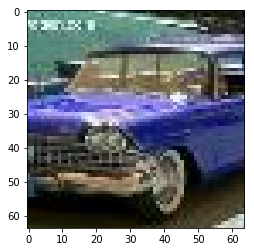

In [7]:
showImage(inTainSet= trainSet, atPosition=4000)

# First step: Pre-processing

From the article we need to :
"The only pre-processing we do is substracting the mean RGB value, computed on the training set, from each pixel"

In [8]:
def normalize_image(trainingSet):
    size = trainingSet.shape[0]*trainingSet.shape[1]*trainingSet.shape[2]*trainingSet.shape[3] #total number of pixel in the training set
    accum = 0 #variable to sum all the values
    
    for im in range(0,trainingSet.shape[0]): #pass throught all images
        for row in range(0,trainingSet.shape[1]): #pass throught all rows in the current image
            for col in range(0,trainingSet.shape[2]):  #pass throught all column in the current row of the current image 
                for channel in range(0,trainingSet.shape[3]): #pass throught all channel in the current column of the current row of the current image
                    accum += trainingSet[im,row,col,channel]
                    
    mean = accum / (size) #calculate the mean pixel value of the training set
    
    for im in range(0,trainingSet.shape[0]):
        for row in range(0,trainingSet.shape[1]): 
            for col in range(0,trainingSet.shape[2]):   
                for channel in range(0,trainingSet.shape[3]):
                    trainingSet[im,row,col,channel] = trainingSet[im,row,col,channel] - mean # substract the mean value to all pixel of the training set

In [ ]:
normalize_image(trainingSet=trainSet)

In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [ ]:
labelSet = convert_to_one_hot(reshapeLabels.T.astype(np.int32), 200).T

In [1]:
labelSet[0]

NameError: name 'labelSet' is not defined

In [ ]:
showImage(inTainSet= trainSet, atPosition=4000)

# Second step: create variables and placeholders

In [ ]:
def create_weights(shape, name):
    return tf.get_variable(name=name, shape=shape, initializer= tf.initializers.truncated_normal(stddev=0.05))
 
def create_biases(size, name):
    return tf.get_variable(name=name, shape=[size], initializer= tf.zeros_initializer())

In [ ]:
def create_placeholders(img_size, num_channels, num_classes):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 199, so -> 200)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - Use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """
    
    X = tf.placeholder(name='X', dtype=tf.float32, shape=[None, img_size,img_size,num_channels])
    Y = tf.placeholder(name='Y', dtype=tf.int32, shape=[None, num_classes])

    return X, Y

# Third step: create convolutionnal layers

In [ ]:
def create_convolutional_layer(input,
               num_input_channels, 
               conv_filter_size,        
               num_filters,
               layer_number):  
    """
    TF's conv2d function calculates convolutions in batches and uses a slightly different format. 
    For an input it is [batch, in_height, in_width, in_channels] 
    For the filter it is [filter_height, filter_width, in_channels, out_channels]
    """
    
    ## We shall define the weights that will be trained using create_weights function.
    weights = create_weights(name='Wconv_'+layer_number, shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    ## We create biases using the create_biases function. These are also trained.
    biases = create_biases(name='Bconv_'+layer_number, size=num_filters)
 
    ## Creating the convolutional layer
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')
 
    layer += biases
 
    return layer

In [ ]:
def create_pooling_layer(input, parameters):  

    ksize = parameters['size_pooling'] #example [1, 2, 2, 1] corresponding [batch_size, img_size, img_size, number of channel]
    strides = parameters['strides_pooling'] #example [1, 2, 2, 1] corresponding [batch_size, img_size, img_size, number of channel]
    padding = parameters['padding'] #example 'SAME' or 'VALID'
    
    ## "Max-pooling is performed over a 2x2 pixel window, with stride 2".  
    layer = tf.nn.max_pool(value=input,
                            ksize=ksize,
                            strides=strides,
                            padding=padding)
 
    return layer

In [ ]:
def create_activation_layer(input):  
    ## "All hidden layers are equipped with the rectification non-linearity"
    layer = tf.nn.relu(input)
 
    return layer

# Fourth step: create fully connected layers

In [ ]:
def create_fully_connected_layer(input, num_input_channels, num_output_channel, layer_number):
        
    ## We shall define the weights that will be trained using create_weights function.
    weights = create_weights(name='Wfc_'+layer_number, shape=[input.shape[1], input.shape[2], num_input_channels, num_output_channel])
    ## We create biases using the create_biases function. These are also trained.
    biases = create_biases(name='Bfc_'+layer_number, size=num_output_channel)
    
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                    padding= 'VALID')
    
    layer += layer + biases
    
    return layer

# Fifth step: create softmax layer

In [ ]:
def create_softmax_layer(networkOutput, Y):
    """
    Computes the cost
    
    Arguments:
    Output -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as output
    
    Returns:
    the coss entropy
    """
    
    # class number should be one hot encoded to fit tensorflow requirement
    oneHotY = tf.one_hot(Y, depth=200)
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(networkOutput)
    labels = tf.transpose(Y)
    
    return tf.nn.softmax_cross_entropy_with_logits_v2(logits= logits, labels= labels) 

# Sixth step: compute cost

In [ ]:
def compute_cost(softmaxOutput):
    """
    Computes the cost
    
    Arguments:
    softmaxOutput -- output of the softmax layer
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(softmaxOutput)
    ### END CODE HERE ###
    
    return cost

# Ten step: Choose your number of layers and train the model

<img src="images/vgg_configurations.png" style="width:520px;height:525px;">

In [ ]:
def get_parameters_configurationA():
    filter_size_conv1 = 3
    filter_size_conv2 = 3
    filter_size_conv3 = 3
    filter_size_conv3bis = 3
    filter_size_conv4 = 3
    filter_size_conv4bis = 3
    filter_size_conv5 = 3
    filter_size_conv5bis = 3
    
    num_filters_conv1 = 64
    num_filters_conv2 = 128
    num_filters_conv3 = 256
    num_filters_conv3bis = 256
    num_filters_conv4 = 512
    num_filters_conv4bis = 512
    num_filters_conv5 = 512
    num_filters_conv5bis = 512
    
    size_pooling1 = [1, 2, 2, 1] 
    strides_pooling1 = [1, 2, 2, 1]
    padding1 = 'SAME'
    
    parameters_pooling1 = {
                            'size_pooling': size_pooling1,
                            'strides_pooling': strides_pooling1,
                            'padding': padding1
                            }
    
    parameters_pooling2 = parameters_pooling1
    parameters_pooling3 = parameters_pooling1
    parameters_pooling4 = parameters_pooling1
    parameters_pooling5 = parameters_pooling1
    
    num_filters_fc1 = 4096
    num_filters_fc2 = 4096
    num_output_class = 200
    
    parameters= {
               'filter_size_conv1': filter_size_conv1,
               'filter_size_conv2': filter_size_conv2,
               'filter_size_conv3': filter_size_conv3,
               'filter_size_conv3bis': filter_size_conv3bis,
               'filter_size_conv4': filter_size_conv4,
               'filter_size_conv4bis': filter_size_conv4bis,
               'filter_size_conv5': filter_size_conv5,
               'filter_size_conv5bis': filter_size_conv5bis,
               'num_filters_conv1': num_filters_conv1,
               'num_filters_conv2': num_filters_conv2,
               'num_filters_conv3': num_filters_conv3,
               'num_filters_conv3bis': num_filters_conv3bis,
               'num_filters_conv4': num_filters_conv4,
               'num_filters_conv4bis': num_filters_conv4bis,
               'num_filters_conv5': num_filters_conv5,
               'num_filters_conv5bis': num_filters_conv5bis,
               'parameters_pooling1': parameters_pooling1,
               'parameters_pooling2': parameters_pooling2,
               'parameters_pooling3': parameters_pooling3,
               'parameters_pooling4': parameters_pooling4,
               'parameters_pooling5': parameters_pooling5,
               'num_filters_fc1': num_filters_fc1,
               'num_filters_fc2': num_filters_fc2,
               'num_output_class': num_output_class
    }
    
    return parameters

In [ ]:
def configuration_A(X, parameters):
    
    filter_size_conv1 = parameters['filter_size_conv1']
    filter_size_conv2 = parameters['filter_size_conv2']
    filter_size_conv3 = parameters['filter_size_conv3']
    filter_size_conv3bis = parameters['filter_size_conv3bis']
    filter_size_conv4 = parameters['filter_size_conv4']
    filter_size_conv4bis = parameters['filter_size_conv4bis']
    filter_size_conv5 = parameters['filter_size_conv5']
    filter_size_conv5bis = parameters['filter_size_conv5bis']
    
    num_filters_conv1 = parameters['num_filters_conv1']
    num_filters_conv2 = parameters['num_filters_conv2']
    num_filters_conv3 = parameters['num_filters_conv3']
    num_filters_conv3bis = parameters['num_filters_conv3bis']
    num_filters_conv4 = parameters['num_filters_conv4']
    num_filters_conv4bis = parameters['num_filters_conv4bis']
    num_filters_conv5 = parameters['num_filters_conv5']
    num_filters_conv5bis = parameters['num_filters_conv5bis']
    
    parameters_pooling1 = parameters['parameters_pooling1']
    parameters_pooling2 = parameters['parameters_pooling2']
    parameters_pooling3 = parameters['parameters_pooling3']
    parameters_pooling4 = parameters['parameters_pooling4']
    parameters_pooling5 = parameters['parameters_pooling5']
    
    num_filters_fc1 = parameters['num_filters_fc1']
    num_filters_fc2 = parameters['num_filters_fc2']
    num_output_class = parameters['num_output_class']
    
    num_input_channels_conv1 = X.shape[3]
    
    layer_conv1 = create_convolutional_layer(input=X, conv_filter_size=filter_size_conv1, num_filters=num_filters_conv1, num_input_channels=num_input_channels_conv1, layer_number='1')
    layer_maxpool1 = create_pooling_layer(input=layer_conv1, parameters=parameters_pooling1)
    
    layer_conv2 = create_convolutional_layer(input=layer_maxpool1, conv_filter_size=filter_size_conv2, num_filters=num_filters_conv2, num_input_channels=num_filters_conv1, layer_number='2')
    layer_maxpool2 = create_pooling_layer(input=layer_conv2, parameters=parameters_pooling2)
    
    layer_conv3 = create_convolutional_layer(input=layer_maxpool2, conv_filter_size=filter_size_conv3, num_filters=num_filters_conv3, num_input_channels=num_filters_conv2, layer_number='3')
    layer_conv3bis = create_convolutional_layer(input=layer_conv3, conv_filter_size=filter_size_conv3bis, num_filters=num_filters_conv3bis, num_input_channels=num_filters_conv3, layer_number='3bis')
    layer_maxpool3 = create_pooling_layer(input=layer_conv3bis, parameters=parameters_pooling3)
    
    layer_conv4 = create_convolutional_layer(input=layer_maxpool3, conv_filter_size=filter_size_conv4, num_filters=num_filters_conv4, num_input_channels=num_filters_conv3bis, layer_number='4')
    layer_conv4bis = create_convolutional_layer(input=layer_conv4, conv_filter_size=filter_size_conv4bis, num_filters=num_filters_conv4bis, num_input_channels=num_filters_conv4, layer_number='4bis')
    layer_maxpool4 = create_pooling_layer(input=layer_conv4bis, parameters=parameters_pooling4)
    
    layer_conv5 = create_convolutional_layer(input=layer_maxpool4, conv_filter_size=filter_size_conv5, num_filters=num_filters_conv5, num_input_channels=num_filters_conv4bis, layer_number='5')
    layer_conv5bis = create_convolutional_layer(input=layer_conv5, conv_filter_size=filter_size_conv5bis, num_filters=num_filters_conv5bis, num_input_channels=num_filters_conv5, layer_number='5bis')
    layer_maxpool5 = create_pooling_layer(input=layer_conv5bis, parameters=parameters_pooling5)
    layer_fc1 = create_fully_connected_layer(input=layer_maxpool5, num_input_channels=num_filters_conv5bis, num_output_channel=num_filters_fc1, layer_number='1')
    layer_fc2 = create_fully_connected_layer(input=layer_fc1, num_input_channels=num_filters_fc1, num_output_channel=num_filters_fc2, layer_number='2')
    layer_fc3 = create_fully_connected_layer(input=layer_fc2, num_input_channels=num_filters_fc2, num_output_channel=num_output_class, layer_number='3')
    
    return layer_fc3

In [ ]:
def random_mini_batches(X, Y, mini_batch_size = 32, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (number of examples, img width, image height, number of channel)
    Y -- true "label" vector (containing int number of the class value), of shape (number of examples, 1)
    mini_batch_size - size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[permutation, :].reshape((m, Y.shape[1]))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


In [ ]:
def model(X_train, Y_train, learning_rate = 0.01, configuration= 'configuration_A',
          num_epochs = 100, minibatch_size = 32, momentum = 0.9, use_nesterov = False, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (m, n_w, n_h, n_c) = X_train.shape                # (m : number of examples in the train set, n_w: image width, n_h: image height, n_c: number of image channel)
    n_y = Y_train.shape[1]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(img_size=n_w, num_channels=n_c, num_classes=n_y)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    if configuration == 'configuration_A':
        parameters = get_parameters_configurationA()
        configuration_output = configuration_A(X=X,parameters=parameters)
    
    #Create softmax layer
    softmax_layer = create_softmax_layer(Y=Y, networkOutput=configuration_output)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(softmaxOutput=softmax_layer)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum, use_nesterov=use_nesterov).minimize(cost)
    #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                  
                print("minibatch cost: %f" % minibatch_cost )
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        
        return parameters

In [ ]:
model(X_train=trainSet, Y_train=labelSet, configuration='configuration_A', momentum= 0.9, num_epochs=50,learning_rate=0.01, minibatch_size=32, use_nesterov=False, print_cost= True)



In [ ]:
labelTrainSet[0]